<a href="https://colab.research.google.com/github/the-rebooted-coder/Stock-Prediction-Major/blob/main/Stock_Prediction_Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
#yahoo finance as data source
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [224]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [225]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [226]:
type(data)

pandas.core.frame.DataFrame

In [227]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-08,664.049988,689.900024,664.049988,685.700012,678.230042,480717
2017-12-11,680.000000,682.750000,671.049988,674.750000,667.399292,122163
2017-12-12,671.049988,682.000000,671.000000,676.049988,668.685120,121938
2017-12-13,671.049988,682.000000,657.000000,675.349976,667.992798,260250
2017-12-14,675.099976,683.000000,673.299988,679.900024,672.493164,444539


In [228]:
len(data)

1235

In [229]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-02,1292.000000,1299.949951,1265.000000,1295.150024,1295.150024,1614314
2022-12-05,1298.099976,1298.099976,1273.650024,1284.550049,1284.550049,684421
2022-12-06,1286.000000,1313.500000,1281.550049,1285.099976,1285.099976,1991151
2022-12-07,1285.900024,1296.599976,1259.000000,1262.050049,1262.050049,636553
2022-12-08,1242.000000,1262.050049,1242.000000,1255.300049,1255.300049,355749


In [230]:
opn = data[['Open']]

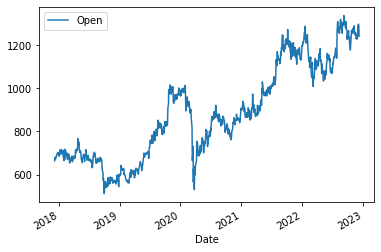

In [231]:
opn.plot()

In [232]:
import matplotlib.pyplot as plt

In [233]:
ds = opn.values

In [234]:
ds

array([[ 664.04998779],
       [ 680.        ],
       [ 671.04998779],
       ...,
       [1286.        ],
       [1285.90002441],
       [1242.        ]])

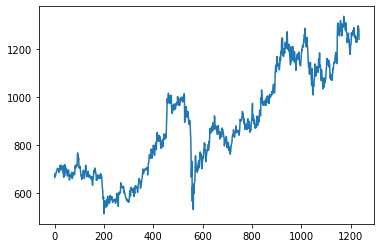

In [235]:
plt.plot(ds)

In [236]:
import numpy as np

In [237]:
from sklearn.preprocessing import MinMaxScaler

In [238]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [239]:
len(ds_scaled), len(ds)

(1235, 1235)

In [240]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [241]:
train_size,test_size

(864, 371)

In [242]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [243]:
len(ds_train),len(ds_test)

(864, 371)

In [244]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [245]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [246]:
X_train.shape,y_train.shape

((763, 100), (763,))

In [247]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [248]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [249]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [250]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [251]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 9s 316ms/step - loss: 0.0491 - val_loss: 0.0362
Epoch 2/100
12/12 [==============================] - 2s 208ms/step - loss: 0.0085 - val_loss: 0.0111
Epoch 3/100
12/12 [==============================] - 2s 192ms/step - loss: 0.0052 - val_loss: 0.0149
Epoch 4/100
12/12 [==============================] - 2s 204ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 5/100
12/12 [==============================] - 3s 212ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 6/100
12/12 [==============================] - 2s 205ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 7/100
12/12 [==============================] - 2s 209ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 8/100
12/12 [==============================] - 2s 206ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 9/100
12/12 [==============================] - 2s 180ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 10/100
12/12 [==============================] - 2s 182ms/step - loss: 0.0027 - val_lo

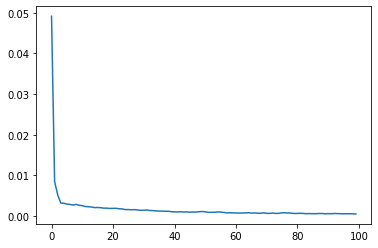

In [252]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [253]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 34ms/step


In [254]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

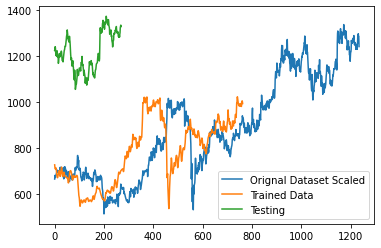

In [255]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled), label = 'Orignal Dataset Scaled')
plt.plot(train_predict, label  ='Trained Data')
plt.plot(test_predict, label = 'Testing')
plt.legend(loc='lower right')
plt.show()

In [256]:
type(train_predict)

numpy.ndarray

In [257]:
test = np.vstack((train_predict,test_predict))

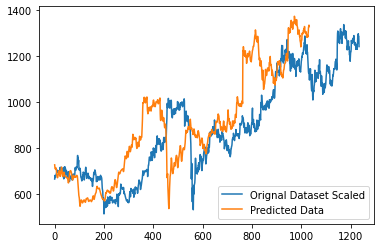

In [258]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled), label = 'Orignal Dataset Scaled')
plt.plot(test, label = 'Predicted Data')
plt.legend(loc = 'lower right')

In [259]:
len(ds_test)

371

In [260]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [261]:
fut_inp = fut_inp.reshape(1,-1)

In [262]:
tmp_inp = list(fut_inp)

In [263]:
fut_inp.shape

(1, 101)

In [264]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [265]:
#Predicting next 30 days prices uing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.9546841979026794], [0.9961465001106262], [1.0351557731628418], [1.0690199136734009], [1.098667860031128], [1.1251240968704224], [1.149741768836975], [1.1737070083618164], [1.1977990865707397], [1.2223682403564453], [1.2474356889724731], [1.2728265523910522], [1.2982879877090454], [1.3235690593719482], [1.348463535308838], [1.3728197813034058], [1.3965351581573486], [1.4195412397384644], [1.4417896270751953], [1.4632426500320435], [1.4838675260543823], [1.503632664680481], [1.5225118398666382], [1.5404824018478394], [1.5575282573699951], [1.573641300201416], [1.588821530342102], [1.60307776927948], [1.61642587184906], [1.6288886070251465]]


In [266]:
len(ds_scaled)

1235

In [267]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

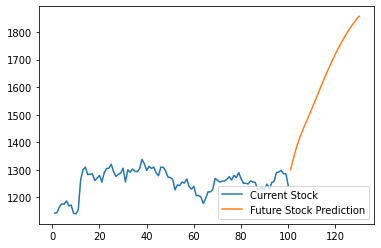

In [268]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1135:]), label = 'Current Stock')
plt.plot(plot_pred, normalizer.inverse_transform(lst_output), label = 'Future Stock Prediction')
plt.legend(loc = 'lower right')

In [269]:
ds_new = ds_scaled.tolist()

In [270]:
len(ds_new)

1235

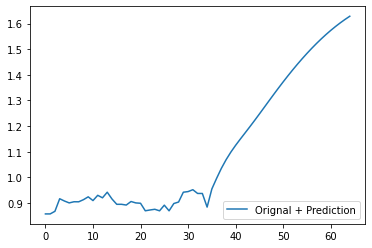

In [271]:
#Extend helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:], label = 'Orignal + Prediction')
plt.legend (loc = 'lower right')

In [272]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

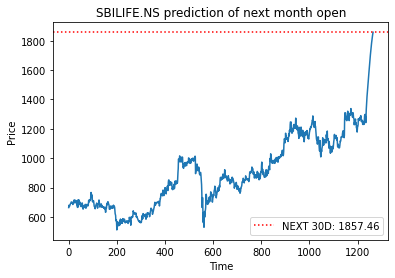

In [273]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()